# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [5]:
!git clone https://github.com/IdePHICS/FundamentalLearningEPFL.git

fatal: destination path 'FundamentalLearningEPFL' already exists and is not an empty directory.


In [6]:
import sys
sys.path.append('/content/FundamentalLearningEPFL/TP10/')
import training_utils

In [7]:
import importlib, types
imp = types.ModuleType("imp")
imp.reload = importlib.reload
sys.modules["imp"] = imp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [9]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

mps


In [10]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

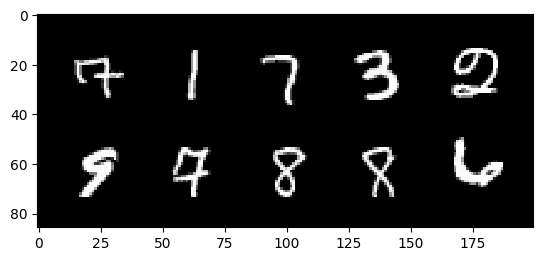

In [11]:
visualize_images(train_dataloader)

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [13]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.4614809458538638
Epoch 1: Loss=0.4090358827073695
Epoch 2: Loss=0.2452201022435043
Epoch 3: Loss=0.1928572407213308
Epoch 4: Loss=0.16200388829081747
Epoch 5: Loss=0.13984298731310893
Epoch 6: Loss=0.12470306493973328
Epoch 7: Loss=0.11414111670801196
Epoch 8: Loss=0.10379547853085955
Epoch 9: Loss=0.09759838626546374
Test set: Avg. loss: 0.0886, Accuracy: 9739/10000 (97%)


(0.08864730186462402, tensor(97.3900, device='mps:0'))

## CIFAR10

In [14]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

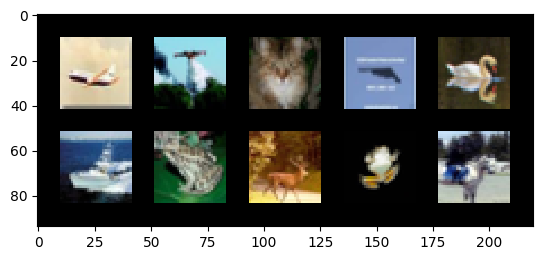

In [15]:
visualize_images(train_dataloader)

In [16]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.251029651992175
Epoch 1: Loss=2.1425421189288705
Epoch 2: Loss=2.0188408287204043
Epoch 3: Loss=1.9036277410935383
Epoch 4: Loss=1.8297569727411076
Epoch 5: Loss=1.7138203942045873
Epoch 6: Loss=1.661384653071968
Epoch 7: Loss=1.6156196569909855
Epoch 8: Loss=1.568224858264534
Epoch 9: Loss=1.527811522386512
Test set: Avg. loss: 1.5007, Accuracy: 4751/10000 (48%)


(1.5006716674804688, tensor(47.5100, device='mps:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [17]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [18]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Let's modify the fit function to also use a validation set.

In [19]:
from typing import Optional

def fit(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

### Learning rate
**Question** Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

In [20]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.001

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

mps


In [21]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [22]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.2991
Epoch 1: Train Loss=2.2931
Epoch 2: Train Loss=2.2872
Epoch 3: Train Loss=2.2813
Epoch 4: Train Loss=2.2752
Epoch 5: Train Loss=2.2689
Epoch 6: Train Loss=2.2625
Epoch 7: Train Loss=2.2556
Epoch 8: Train Loss=2.2484
Epoch 9: Train Loss=2.2407
Test set: Avg. loss: 2.2357, Accuracy: 3680/10000 (37%)


(2.235685009765625, tensor(36.8000, device='mps:0'))

**Answer** : With a learning rate of 0.001, the model performs noticeably worse because it learns far too slowly relative to the number of training epochs. When the learning rate is this small, each gradient update only makes a tiny adjustment to the weights, so the network barely moves toward a good minimum of the loss function. As a result, it remains close to its initial parameters and does not have enough time to properly learn the structure of the data, leading to clear underfitting. With more epochs, the model could eventually reach better performance, but under a fixed training budget, a learning rate that is too small directly limits how much the model can improve.

**Question** Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitatively) what happens.

In [23]:
LEARNING_RATE = 0.6

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x

In [25]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.6)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Train Loss=2.2753
Epoch 1: Train Loss=2.3075
Epoch 2: Train Loss=2.3015
Epoch 3: Train Loss=2.3015
Epoch 4: Train Loss=2.3014
Epoch 5: Train Loss=2.3015
Epoch 6: Train Loss=2.3014
Epoch 7: Train Loss=2.3015
Epoch 8: Train Loss=2.3015
Epoch 9: Train Loss=2.3014
Test set: Avg. loss: 2.3010, Accuracy: 1135/10000 (11%)


(2.3009682739257813, tensor(11.3500, device='mps:0'))

**Answer** : When the learning rate becomes very large (for example > 0.5), the model usually performs even worse than with a very small learning rate, but for the opposite reason. With such a high step size, gradient descent makes huge jumps in parameter space. Instead of moving gradually toward a minimum of the loss function, the algorithm repeatedly overshoots it: every update pushes the weights far past the region where the loss is small. The optimization becomes unstable, the loss oscillates or even explodes, and the network cannot settle into a meaningful solution. As a result, the model fails to learn useful representations, and its accuracy collapses. So while a tiny learning rate causes slow learning and underfitting, an excessively large one causes no learning at all because the updates are too violent for the model to converge.

### Optimizer

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



**Question** Implement momentum and compute the learning curve. How does this change affect performance?

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perform a grid search; define a list of choices for each hyperparameter and search over all combinations.


**Question** Perform a grid search over the learning rate and batch size. What is the best combination? 

In [26]:
import torch

In [27]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [28]:
# -----------------------------
# Grid Search
# -----------------------------
learning_rates = [0.1,0.05, 0.01, 0.001]
batch_sizes = batch_sizes = [ 128, 256, 512, 1024,2048]


for learn in learning_rates:
    for bs in batch_sizes:
       
        # define the hyperparameters
        BATCH_SIZE = bs
        TEST_BATCH_SIZE = 1024
        LEARNING_RATE = learn
        
        # find out which device is available
        DEVICE = None
        if torch.cuda.is_available():
            DEVICE = torch.device("cuda")
            
        elif torch.mps.is_available():# Requires Apple computer with M1 or later chip
            DEVICE = torch.device("mps")
        
        else:# Not recommended, because it's slow. Move to Google Colab!
            DEVICE = torch.device("cpu")
            
        print(DEVICE)
        
        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=2)
        
        valid_dataloader = DataLoader(
            dataset=valid_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)
        
        test_dataloader = DataLoader(
            dataset=test_dataset,
            batch_size=TEST_BATCH_SIZE,
            shuffle=False,
            num_workers=2)
        
        
        print(f"Training with lr={learn}, batch_size={bs}...")
        
        # initialize model
        cnn = CNN().to(DEVICE)
        # define the optimizer
        optimizer = torch.optim.SGD(cnn.parameters(), lr=learn)
        
        # train the CNN
        losses = fit(
             model=cnn,
             train_dataloader=train_dataloader,
             optimizer=optimizer,
             epochs=10,
             device=DEVICE
             )
       
        predict(model=cnn, test_dataloader=valid_dataloader, device=DEVICE)
        print("***********************************************************")

mps
Training with lr=0.1, batch_size=128...
Epoch 0: Train Loss=0.4067
Epoch 1: Train Loss=0.1134
Epoch 2: Train Loss=0.0850
Epoch 3: Train Loss=0.0709
Epoch 4: Train Loss=0.0623
Epoch 5: Train Loss=0.0550
Epoch 6: Train Loss=0.0495
Epoch 7: Train Loss=0.0456
Epoch 8: Train Loss=0.0424
Epoch 9: Train Loss=0.0394
Test set: Avg. loss: 0.0708, Accuracy: 9780/10000 (98%)
***********************************************************
mps
Training with lr=0.1, batch_size=256...
Epoch 0: Train Loss=0.5948
Epoch 1: Train Loss=0.1659
Epoch 2: Train Loss=0.1180
Epoch 3: Train Loss=0.0958
Epoch 4: Train Loss=0.0824
Epoch 5: Train Loss=0.0728
Epoch 6: Train Loss=0.0682
Epoch 7: Train Loss=0.0623
Epoch 8: Train Loss=0.0574
Epoch 9: Train Loss=0.0545
Test set: Avg. loss: 0.1105, Accuracy: 9645/10000 (96%)
***********************************************************
mps
Training with lr=0.1, batch_size=512...
Epoch 0: Train Loss=0.9132
Epoch 1: Train Loss=0.2304
Epoch 2: Train Loss=0.1655
Epoch 3: Train 

The best-performing combination was obtained with the highest learning rate (0.1) together with the smallest batch size. We have already discussed the trade-off between high and low learning rates relative to the number of training iterations, so we will not repeat that here. Concerning the batch size, a smaller batch likely helps because MNIST consists of subtle differences in handwritten digits, where classification relies on fine local pixel variations. Smaller batches introduce more gradient noise, which can help the model capture these delicate details and avoid oversmoothing, ultimately improving performance on this dataset.

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings works out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [29]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torch.nn.functional as F

In [30]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


In [31]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. What does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Let's redo the previous cnn architecture with batch normalization. 
Observe where the batch normalization goes.

In [32]:
class CNNwithBN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

Epoch 0: Train Loss=1.7457
Epoch 1: Train Loss=1.3347
Epoch 2: Train Loss=1.1801
Epoch 3: Train Loss=1.0740
Epoch 4: Train Loss=1.0121
Epoch 5: Train Loss=0.9667
Epoch 6: Train Loss=0.9340
Epoch 7: Train Loss=0.8990
Epoch 8: Train Loss=0.8759
Epoch 9: Train Loss=0.8563
Epoch 10: Train Loss=0.8366
Epoch 11: Train Loss=0.8169
Epoch 12: Train Loss=0.7894
Epoch 13: Train Loss=0.7672
Epoch 14: Train Loss=0.7578
Epoch 15: Train Loss=0.7498
Epoch 16: Train Loss=0.7327
Epoch 17: Train Loss=0.7253
Epoch 18: Train Loss=0.7052
Epoch 19: Train Loss=0.7081
Epoch 20: Train Loss=0.6896
Epoch 21: Train Loss=0.6843
Epoch 22: Train Loss=0.6657
Epoch 23: Train Loss=0.6606
Epoch 24: Train Loss=0.6557
Epoch 25: Train Loss=0.6451
Epoch 26: Train Loss=0.6488
Epoch 27: Train Loss=0.6345
Epoch 28: Train Loss=0.6215
Epoch 29: Train Loss=0.6158
Test set: Avg. loss: 0.9649, Accuracy: 6819/10000 (68%)


(0.9648902221679687, tensor(68.1900, device='mps:0'))

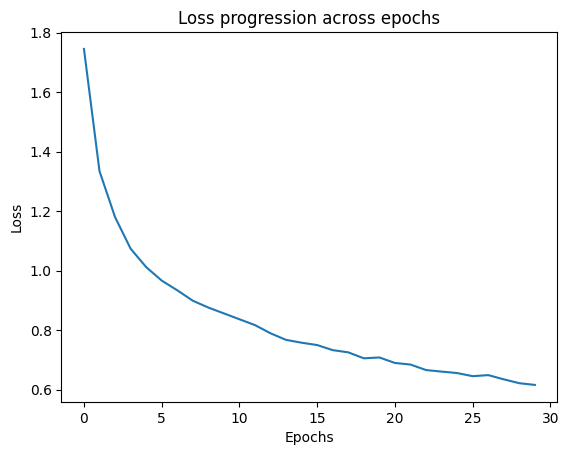

In [33]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question** One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


Epoch 0: Train Loss=2.9947
Epoch 1: Train Loss=1.5792
Epoch 2: Train Loss=1.4615
Epoch 3: Train Loss=1.3962
Epoch 4: Train Loss=1.3183
Epoch 5: Train Loss=1.2635
Epoch 6: Train Loss=1.2067
Epoch 7: Train Loss=1.1677
Epoch 8: Train Loss=1.1428
Epoch 9: Train Loss=1.1155
Epoch 10: Train Loss=1.0987
Epoch 11: Train Loss=1.0699
Epoch 12: Train Loss=1.0559
Epoch 13: Train Loss=1.0335
Epoch 14: Train Loss=1.0169
Epoch 15: Train Loss=1.0061
Epoch 16: Train Loss=0.9876
Epoch 17: Train Loss=0.9797
Epoch 18: Train Loss=0.9650
Epoch 19: Train Loss=0.9531
Epoch 20: Train Loss=0.9402
Epoch 21: Train Loss=0.9275
Epoch 22: Train Loss=0.9149
Epoch 23: Train Loss=0.8975
Epoch 24: Train Loss=0.8879
Epoch 25: Train Loss=0.8881
Epoch 26: Train Loss=0.8698
Epoch 27: Train Loss=0.8674
Epoch 28: Train Loss=0.8499
Epoch 29: Train Loss=0.8472
Test set: Avg. loss: 1.0162, Accuracy: 6569/10000 (66%)


(1.0161607421875, tensor(65.6900, device='mps:0'))

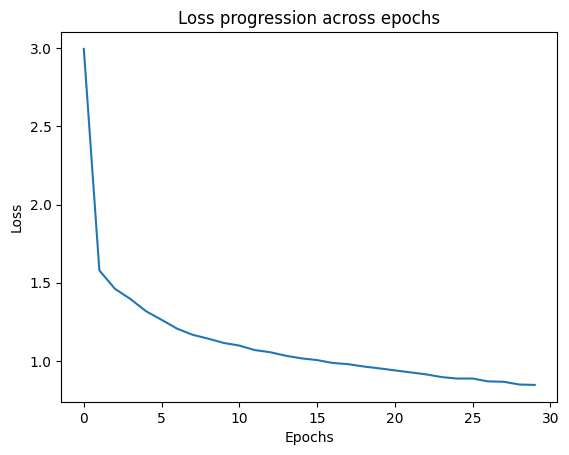

In [34]:
# YOUR CODE HERE 

cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

Epoch 0: Train Loss=3.5025
Epoch 1: Train Loss=1.6111
Epoch 2: Train Loss=1.4806
Epoch 3: Train Loss=1.3876
Epoch 4: Train Loss=1.3369
Epoch 5: Train Loss=1.2938
Epoch 6: Train Loss=1.2460
Epoch 7: Train Loss=1.2120
Epoch 8: Train Loss=1.1743
Epoch 9: Train Loss=1.1484
Epoch 10: Train Loss=1.1210
Epoch 11: Train Loss=1.0906
Epoch 12: Train Loss=1.0827
Epoch 13: Train Loss=1.0668
Epoch 14: Train Loss=1.0374
Epoch 15: Train Loss=1.0282
Epoch 16: Train Loss=1.0176
Epoch 17: Train Loss=1.0027
Epoch 18: Train Loss=0.9920
Epoch 19: Train Loss=0.9717
Epoch 20: Train Loss=0.9614
Epoch 21: Train Loss=0.9484
Epoch 22: Train Loss=0.9338
Epoch 23: Train Loss=0.9358
Epoch 24: Train Loss=0.9253
Epoch 25: Train Loss=0.9117
Epoch 26: Train Loss=0.8989
Epoch 27: Train Loss=0.8895
Epoch 28: Train Loss=0.8841
Epoch 29: Train Loss=0.8764
Test set: Avg. loss: 1.1727, Accuracy: 6096/10000 (61%)


(1.1727235107421874, tensor(60.9600, device='mps:0'))

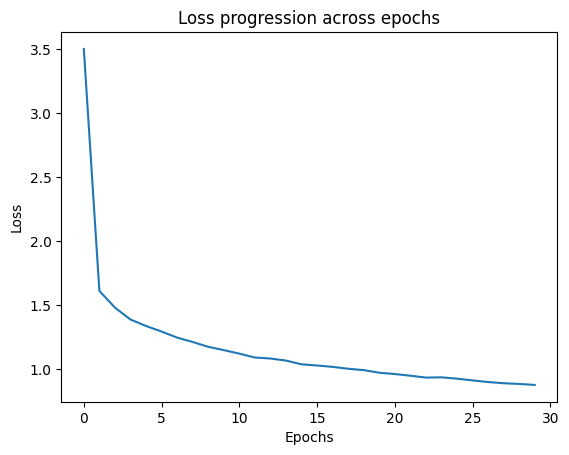

In [35]:
# YOUR CODE HERE 

cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.1, momentum=0.6)

train_losses, valid_losses, valid_accs = fit(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
)

plot_loss(train_losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)

When the learning rate is increased while keeping the momentum at its already high value, the optimizer becomes overly aggressive. As a result, the loss initially drops faster during the first few epochs (for example between epochs 1 and 6), but the updates quickly become unstable and start overshooting the minima. Because of this, the learning curve flattens prematurely and the model reaches a plateau much earlier , around 20 epochs without continuing to improve significantly afterward.

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and we start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

In the following cell, we augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

In [36]:
from training_utils import train_epoch

def fit_scheduler(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: torch.device,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
):
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device,
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

        if scheduler is not None:
            scheduler.step()

    return losses

Now we train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

Epoch 0: Loss=3.2721977376937867
Epoch 1: Loss=1.7798653984069823
Epoch 2: Loss=1.643848648071289
Epoch 3: Loss=1.5431305742263794
Epoch 4: Loss=1.4525867700576782
Epoch 5: Loss=1.397342824935913
Epoch 6: Loss=1.3555505275726318
Epoch 7: Loss=1.3105526208877563
Epoch 8: Loss=1.2790715074539185
Epoch 9: Loss=1.2510983037948609
Epoch 10: Loss=1.2325293111801148
Epoch 11: Loss=1.2074003219604492
Epoch 12: Loss=1.197726674079895
Epoch 13: Loss=1.1755177879333496
Epoch 14: Loss=1.157026867866516
Epoch 15: Loss=1.144511079788208
Epoch 16: Loss=1.1240537071228027
Epoch 17: Loss=1.114830856323242
Epoch 18: Loss=1.0972988080978394
Epoch 19: Loss=1.0824952077865602
Epoch 20: Loss=1.0668852710723877
Epoch 21: Loss=1.0655186510086059
Epoch 22: Loss=1.0542895913124084
Epoch 23: Loss=1.044107003211975
Epoch 24: Loss=1.0316049861907959
Epoch 25: Loss=1.0001234602928162
Epoch 26: Loss=0.9893879151344299
Epoch 27: Loss=0.985819571018219
Epoch 28: Loss=0.9853461790084839
Epoch 29: Loss=0.984010381698608

(1.0854484741210937, tensor(62.5600, device='mps:0'))

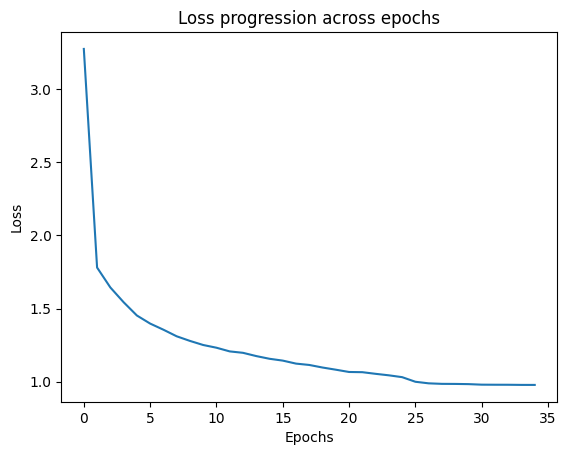

In [37]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 30],
    gamma=0.1,
)


losses =   fit_scheduler(
        cnn2,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE,
        scheduler=scheduler,
)

plot_loss(losses)

predict(
    cnn2,
    test_dataloader = test_dataloader,
    device = DEVICE
)


## Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [38]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [39]:
# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )


Epoch 0: Train Loss=2.2945
Epoch 1: Train Loss=1.9445
Epoch 2: Train Loss=1.8165
Epoch 3: Train Loss=1.7289
Epoch 4: Train Loss=1.6284
Epoch 5: Train Loss=1.5162
Epoch 6: Train Loss=1.4156
Epoch 7: Train Loss=1.3383
Epoch 8: Train Loss=1.2598
Epoch 9: Train Loss=1.1541
Epoch 10: Train Loss=1.0900
Epoch 11: Train Loss=1.0153
Epoch 12: Train Loss=0.9449
Epoch 13: Train Loss=0.8889
Epoch 14: Train Loss=0.8012
Epoch 15: Train Loss=0.7597
Epoch 16: Train Loss=0.6970
Epoch 17: Train Loss=0.6397
Epoch 18: Train Loss=0.5968
Epoch 19: Train Loss=0.5344
Epoch 20: Train Loss=0.5148
Epoch 21: Train Loss=0.4570
Epoch 22: Train Loss=0.4172
Epoch 23: Train Loss=0.3856
Epoch 24: Train Loss=0.3469
Epoch 25: Train Loss=0.3064
Epoch 26: Train Loss=0.2730
Epoch 27: Train Loss=0.2527
Epoch 28: Train Loss=0.2236
Epoch 29: Train Loss=0.1885
Epoch 30: Train Loss=0.1606
Epoch 31: Train Loss=0.1462
Epoch 32: Train Loss=0.1292
Epoch 33: Train Loss=0.1050
Epoch 34: Train Loss=0.0866


Test set: Avg. loss: 1.1307, Accuracy: 7597/10000 (76%)


(1.13067314453125, tensor(75.9700, device='mps:0'))

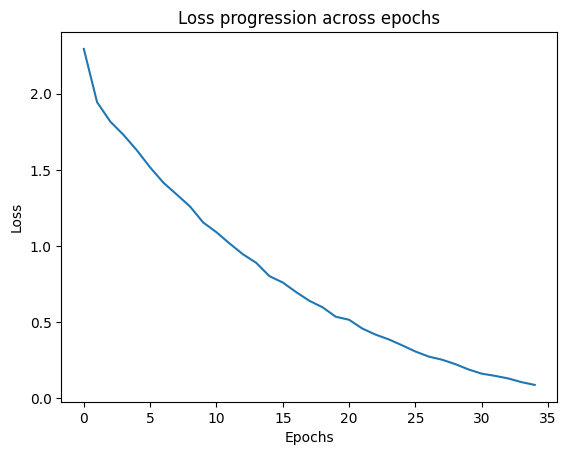

In [40]:

plot_loss(train_losses)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Evaluated part: 

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

**Question** Fill the code below and train the network!

In [41]:
class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
            
    def forward(self, x):
        
        identity = x                         # save original input
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        shortcut = self.shortcut(identity)   # apply shortcut to original x
        out = out + shortcut                 # residual addition
        out = F.relu(out)
         
         
        return out

Epoch 0: Train Loss=2.5495
Epoch 1: Train Loss=1.8839
Epoch 2: Train Loss=1.6308
Epoch 3: Train Loss=1.4819
Epoch 4: Train Loss=1.3813
Epoch 5: Train Loss=1.2381
Epoch 6: Train Loss=1.1186
Epoch 7: Train Loss=0.9938
Epoch 8: Train Loss=0.8889
Epoch 9: Train Loss=0.8254
Epoch 10: Train Loss=0.7264
Epoch 11: Train Loss=0.6372
Epoch 12: Train Loss=0.5539
Epoch 13: Train Loss=0.4902
Epoch 14: Train Loss=0.3928
Epoch 15: Train Loss=0.3335
Epoch 16: Train Loss=0.2528
Epoch 17: Train Loss=0.1992
Epoch 18: Train Loss=0.1579
Epoch 19: Train Loss=0.1112
Epoch 20: Train Loss=0.0869
Epoch 21: Train Loss=0.0668
Epoch 22: Train Loss=0.0462
Epoch 23: Train Loss=0.0390
Epoch 24: Train Loss=0.0285
Epoch 25: Train Loss=0.0296
Epoch 26: Train Loss=0.0271
Epoch 27: Train Loss=0.0299
Epoch 28: Train Loss=0.0334
Epoch 29: Train Loss=0.0330
Epoch 30: Train Loss=0.0288
Epoch 31: Train Loss=0.0254
Epoch 32: Train Loss=0.0237
Epoch 33: Train Loss=0.0221
Epoch 34: Train Loss=0.0201
Test set: Avg. loss: 1.3411, A

(1.3410621337890625, tensor(77.7900, device='mps:0'))

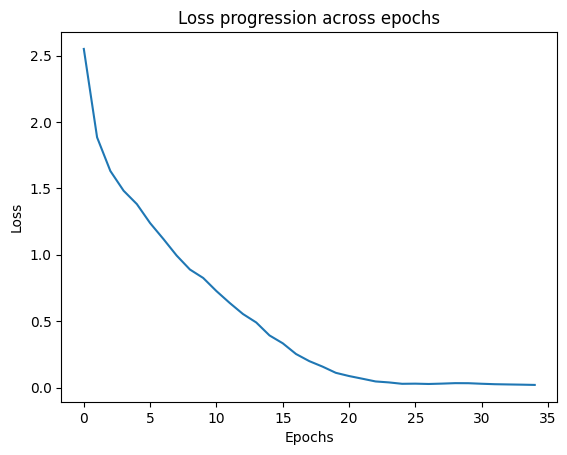

In [42]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

train_losses, valid_losses, valid_accs =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )
plot_loss( train_losses )

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)

**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!

Epoch 0: Loss=2.6275832939147947
Epoch 1: Loss=1.9823900413513185
Epoch 2: Loss=1.7910129022598267
Epoch 3: Loss=1.5932344722747802
Epoch 4: Loss=1.4528701400756836
Epoch 5: Loss=1.3564950275421142
Epoch 6: Loss=1.222375249862671
Epoch 7: Loss=1.1129763841629028
Epoch 8: Loss=1.020311484336853
Epoch 9: Loss=0.9490794944763183
Epoch 10: Loss=0.8448799633979798
Epoch 11: Loss=0.7598707199096679
Epoch 12: Loss=0.6818592977523804
Epoch 13: Loss=0.6126739835739136
Epoch 14: Loss=0.5493864917755127
Epoch 15: Loss=0.461159371137619
Epoch 16: Loss=0.39300023078918456
Epoch 17: Loss=0.3145489311218262
Epoch 18: Loss=0.2479032665491104
Epoch 19: Loss=0.1847791314125061
Epoch 20: Loss=0.1497235119342804
Epoch 21: Loss=0.11239473938941956
Epoch 22: Loss=0.0810502478480339
Epoch 23: Loss=0.06509106025099755
Epoch 24: Loss=0.06819430068135261
Epoch 25: Loss=0.025105506107211115
Epoch 26: Loss=0.006894018854945898
Epoch 27: Loss=0.0041733331512659785
Epoch 28: Loss=0.0034217562340199945
Epoch 29: Los

(0.9903952758789063, tensor(79.7800, device='mps:0'))

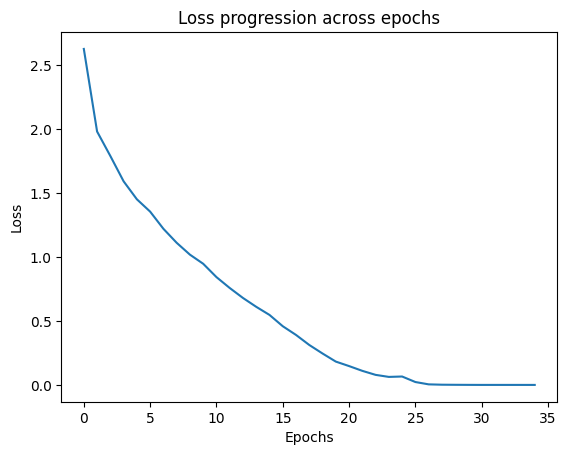

In [43]:
# initialize the model
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[25, 30],
    gamma=0.1,
)

# train the ResNet

losses =   fit_scheduler(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE,
        scheduler=scheduler,
)

plot_loss(losses)


# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)

